In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [2]:
#A beam is defined as [[px,py,pz],[qx,qy,qz]] where p is the direction and q is the position

class surface:
    """ Spherical surface  """
    #center=np.array([0,0,2.])
    C=0.001    #1/Radius of curvature
    n=1      #index of refraction
    d=50     #diameter of the lens
    pos=0    #position (Point where surface intersects z-Axis)
    n0=1     #index of refraction before surface
    k=0
    def __init__(self,pos=1,curv=1E-20,n0=1.5,n2=1,diameter=50):
        self.d=diameter
        self.n=n2
        self.n0=n0
        self.pos=pos
        self.set_Curv(curv)
    def center(self):
        """ Return center of sphere"""
        return np.array([0,0,1/self.C+self.pos])
    def set_Power(self,power):
        """sets the refraction power. The radius is then (n2-n0)/power """
        n2=self.n
        n0=self.n0
        self.C=1/((n2-n0+1E-30)/(power+1.E-40))
    def set_Curv(self,curv):
        """sets the refraction power. The radius is then (n2-n0)/power """
        n2=self.n
        n0=self.n0
        self.C=(curv+1.E-40)
    def R(self):
        return 1/self.C
    def normal(self,points):   
        """return surface normals at points=[p1,p2,...,pn] where pi are points on surface """
        v=points-self.center()
        return (v.T/np.linalg.norm(v,axis=1)).T*np.sign(self.C)
    def plot(self,**kwargs):
        R=self.R()
        C=self.C
        k=self.k
        ylim=min(abs(R)*0.95,self.d/2)
        y=np.linspace(self.center()[1]-ylim,self.center()[1]+ylim,100)
        z=self.center()[2]-np.sign(R)*np.sqrt(R**2-y**2)
        #z=C*y**2/(1+np.sqrt(1-(1+k)*C**2*R**2))+self.pos
        plt.plot(z,y,**kwargs)
        
    #a beam is defined as q the position and P the direction
class beam_field:
   # Qa=np.array([[0,0,0],[0,0.1,0]])   #position of the beams [q1,q2,...,qn] where qi is the 3d pos of each beam
   # Pa=np.array([[0,0.1,1],[0,0.1,1]]) #direction of the beams [U1,U2,...,Un] 
    Q_p=None              #[Q1,Q2,...,QM] positions of the beam bundle where Qi=[q1,...,qn] is defined above 
    U=None #array([[[ux,uy,uz]]])  dim0=lensnr, dim1 =beamnr, dim2=coordinate
    n=np.array([1]) #indices of refraction
    def rectangular_grid(self,nx,ny,d,u=0):   #create an array of parallel beams d durchmesser 
        if nx == 1:
            dx=0
        else:
            dx=d
        dy=d
        if ny==1:
            dy=0
        xv, yv = np.mgrid[-dx:dx:nx*1j,-dy:dy:ny*1j]
        self.Q_p=np.array([np.array([xv.flatten(),yv.flatten(),np.zeros(nx*ny)]).T])        
        self.U=np.array([np.tile(np.array([0,u,1])/np.sqrt(u**2+1),(nx*ny,1))])
        self.normalize_U()
    def single_beam_from_Kingslake_Q(self,Qk,Uk):
        """ Create a single beam according to Q values defined
        Q=distance from  point where surface intersects with axis
        U angle against main axis
        """
        U=np.array([0,sin(Uk),cos(Uk)])
        Q=np.array([0,cos(Uk)*Qk,sin(Uk)*Qk])
        #transfer to starting point before lens
        Q=Q-U/np.cos(Uk)*np.sin(Uk)*Qk
        self.Q_p=Q[np.newaxis,np.newaxis,:]
        self.U=U[np.newaxis,np.newaxis,:]
    def normalize_U(self):
        self.U=self.U/np.linalg.norm(self.U,axis=2)[:,:,np.newaxis]
    def Kingslake_Qabs(self,surfaces):
        pos=np.array([s.pos for s in surfaces])
        Q=self.Q_p[:-1]
        U=self.U[:-1]/np.linalg.norm(self.U[:-1],axis=2)[:,:,np.newaxis]
        A=np.array([0,0,1])*pos[:,np.newaxis,np.newaxis]
        Q=Q+np.sum((A-Q)*U,2)[:,:,np.newaxis]*U
        return(np.linalg.norm(Q-A,axis=2))
    def Kingslake_Q_abs(self,surfaces):
        pos=np.array([s.pos for s in surfaces])
        Q=self.Q_p[1:]
        U=self.U[1:]/np.linalg.norm(self.U[1:],axis=2)[:,:,np.newaxis]
        A=np.array([0,0,1])*pos[:,np.newaxis,np.newaxis]
        Q=Q+np.sum((A-Q)*U,2)[:,:,np.newaxis]*U
        return(np.linalg.norm(Q-A,axis=2))
        
    def surface_points(self,surface):  #points where the beams hit the surface
        U=self.U[-1]
        U=U/np.linalg.norm(U,axis=1)[:,np.newaxis] 
        Q=self.Q_p[-1]
        QC=surface.center()-Q
        QCP=np.sum(QC*U,1)    #U normalized
        QC2=np.sum(QC*QC,1) 
        P2=np.sum(U*U,1)
        
        a=(QCP-np.sign(surface.R())*np.sqrt(QCP*QCP+P2*(surface.R()**2-QC2)))/P2
        
        return (U.T*a).T+Q
    def refract(self,s,points):    
        #n0 index of refraction before surface
        #s surface at which the refraction takes place 
                       #for a normalized propagation vector P and a surface normal N and an outgoing P2
                            # the refraction laws can be written as n1*NxP=n2*NxP2
        #P=(self.P.T/np.linalg.norm(self.P,axis=1)).T #normalized propagation vectors                    
        P=self.U[-1] #normalized propagation vectors        
        #n1=np.linalg.norm(P,axis=1)[0]
        n1=self.n[-1]
        #print(n1)
        #print(np.linalg.norm(P,axis=1))
        P=P/np.linalg.norm(P,axis=1)[:,np.newaxis]
        n2=s.n
       
        N=s.normal(points)
        c=n1/n2*np.cross(N,P)                         #c= n1/n2 NxP,   equation c=NxP2 can be written as
        NC=np.cross(N,c)                              #P2=Nxc/N^2+b*N with b=sqrt(1-(NxC/N^2)^2) to normalize P2
        return -1*(NC+(np.sqrt(1-np.sum(NC*NC,1))*N.T).T)
        #print(self.P)
    def propagate(self,surfaces):
        self.Q_p=np.array([self.Q_p[0]])
        self.U=np.array([self.U[0]])
        self.n=np.array([self.n[0]])
        for s in surfaces:
            sp=np.array([self.surface_points(s)])
            
            self.Q_p=np.append(self.Q_p,sp,axis=0)
            newP=self.refract(s,sp[0])    
            #self.Q=sp[0]
            self.U=np.append(self.U,[newP],axis=0)
            self.n=np.append(self.n,[s.n])
    def plot(self,**kwargs):
        defaults={'color':'black','lw':0.1}
        kwargs={**defaults,**kwargs}    
        plt.plot(self.Q_p[:,:,2],self.Q_p[:,:,1],**kwargs)
    def calculate_intersections(self,P1,Q1,P2,Q2):
        """Intersection points between two beams"""
        x=(Q2[:,:,1]-Q1[:,:,1]-P2[:,:,1]/P2[:,:,2]*(Q2[:,:,2]-Q1[:,:,2]))/(P1[:,:,1]-P1[:,:,2]*P2[:,:,1]/P2[:,:,2])
        return Q1+x[:,:,np.newaxis]*P1,x
    def project_onto_plane(self,z): 
        """projects the last beam segment onto a plane"""
        U=self.U
        Q=self.Q_p
        #print(((z-Q[-2,:,[2]])/P[-2,:,[2]]).T)
        #print(P[-2])
        return ((z-Q[-2,:,[2]])/U[-2,:,[2]]).T*U[-2]+Q[-2]
        
class paraxial:
    """Paraxial beam tracing"""
    y=np.array([1.])
    nu=np.array([0.])  # index of refraction n times inclination angle u=sin(u)  
    i=np.array([0.])
    def __init__(self,y,nu):
        """y = starting y value
           nu = index of refraction at start point times u(angle at start) 
        """
        self.y=np.array([y])
        self.nu=np.array([nu])
    def propagate(self,surfaces):
        y=self.y[[0]]
        nu=self.nu[[0]]
        self.i=self.i[[0]]
        nn=np.array([surfaces[0].n0])
        pos=0
        for s in surfaces:
            d=s.pos-pos
            c=s.C
            n=s.n0
            n_=s.n  
            y_=y[-1]-d/n*nu[-1]
            y=np.append(y,[y_])
            #print(y)
            nu_=nu[-1]+y[-1]*(n_-n)*c
            self.i=np.append(self.i,[y[-1]*c-nu[-1]/n])
            nu=np.append(nu,[nu_])
            pos=s.pos
            nn=np.append(nn,[n_])
        self.nu=nu
        self.y=y
        self.n_=nn         
    
        


from scipy.optimize import minimize
class lens_system:  
    """ Handle a whole system of lenses"""
    surfaces=[]
    """list containing the surfaces of the lens system"""
    entrance_pupil=11
    """diameter of entrance pupil"""
    marginal_ray=beam_field()
    """marginal_ray"""
    n_init=1
    def __init__(self,pupil=20):
        """
        Parameters
            pupil:  diameter of entrance pupil
        """
        self.entrance_pupil=pupil
    
    def add_surface(self,s):
        """add a surface to the system. Surfacess must be added ordered by their z value."""
        self.surfaces.append(s)
    def plot(self,**kwargs):
        for s in self.surfaces:
            s.plot(**kwargs)
    def calculate_marginal(self):
        """calculate path of marginal ray"""
        self.marginal_ray=beam_field()
        m=self.marginal_ray
        m.U=np.array([[[0,0,1]]])
        m.Q_p=np.array([[[0,self.entrance_pupil,0]]])
        m.propagate(self.surfaces)
        
    def get_n(self):
        """return list with indices of refraction"""
        return np.append([self.n_init],[s.n for s in self.surfaces])
    def plot_caustic(self,**kwargs):
        defaults={'color':'black','lw':1}
        kwargs={**defaults,**kwargs} 
        f=beam_field()        
        f.rectangular_grid(1,20,self.entrance_pupil)
        f.propagate(self.surfaces)
        i,x=f.calculate_intersections(f.U[-2:-1,1:],f.Q_p[-2:-1,1:],f.U[-2:-1,:-1],f.Q_p[-2:-1,:-1])
        plt.plot(i[0,:,2],i[0,:,1],**kwargs)
    
    def circle_of_least_confusion(self):
        """Circle of least confusion also termed \Sigma_{LC}"""
        ff=beam_field()        
        ff.rectangular_grid(1,500,self.entrance_pupil)
        ff.propagate(self.surfaces)
        def f(x):
            pl=ff.project_onto_plane(x)
            return max(pl[:,1])
            
        m=self.marginal_ray
        if hasattr(self, 'start'):
            start=self.start
        else:
            start=(m.Q_p[-1,0,2]-m.Q_p[-2,0,2])/2
        res=minimize(f,(start), method='Nelder-Mead')
        self.start=res.final_simplex[0][0,0]
        
        return res.final_simplex[0][0,0],res.final_simplex[1][0]
    def calculate_width_helper(self,d):
        m=self.marginal_ray

        n=beam_field()
        n.P_p=np.array([[[0,0,1]]])
        n.U=np.array([[[0,d,0]]])
        n.propagate(self.surfaces)
        i,x=m.calculate_intersections(m.U[-2:-1],m.Q_p[-2:-1],n.U[-2:-1],n.Q_p[-2:-1])
        
        return x[0,0],i
    def calculate_width(self):
        f=lambda x:-self.calculate_width_helper(x)[0]
        res=minimize(f, (-self.entrance_pupil*0.8), method='Nelder-Mead')
        d=res.final_simplex[0][0][0]
        i=self.calculate_width_helper(d)[1]
        #plt.plot(i[0,:,2],i[0,:,1],'o',color='black')
        #print(i[0,0,1])
        return i
    def Spherical_aberrations_surface_addup(self):
        """ the spherical aberrations are the distances between the zero crossings of a paraxial ray and
        the marginal ray. They are not calculated for each surface individually but as a total for a beam passing 
        the first n surfaces (experimental)"""
        bf=beam_field()
        bf.U=np.array([[[0,0,1],[0,0,1],[0,0,1]]])
        pp=self.entrance_pupil
        bf.Q_p=np.array([[[0,0,0],[0,pp/10.,0],[0,pp,0]]])    
        bf.propagate(self.surfaces)
        i,x=bf.calculate_intersections(bf.U[:,[0]],bf.Q_p[:,[0]],bf.U[:,[1]],bf.Q_p[:,[1]])
        
        i2,x2=bf.calculate_intersections(bf.U[:,[0]],bf.Q_p[:,[0]],bf.U[:,[2]],bf.Q_p[:,[2]])
        
        print(i[:,:,2]-i2[:,:,2])
    def OSC(self,u):
        """angle tan: tangens of the paraxial beam angle u"""
        pr=paraxial(0,u)
        hnu=-u*self.entrance_pupil #n=1
        pr.propagate(self.surfaces)
        #print('hnu',hnu,1/hnu)
        #print('paraxial y ',pr.y[1:])
        #print('paraxial nu',pr.nu[:-1])
        #print('paraxial u ',pr.nu[:-1]/self.get_n()[:-1])
        #print('paraxial u ',pr.nu[:-1]/self.get_n()[:-1]/hnu/5.715023)
        #print('paraxial i ',pr.i[1:])
        marginal=beam_field()
        marginal.single_beam_from_Kingslake_Q(self.entrance_pupil,0)   #marginal beam
        marginal.propagate(ls.surfaces)
        Q=marginal.Kingslake_Qabs(ls.surfaces)[:,0]
        Q_=marginal.Kingslake_Q_abs(ls.surfaces)[:,0]
        #print('marginal Q ',bb2.Kingslake_Qabs(ls.surfaces)[:,0])
        #print('marginal Q\'',bb2.Kingslake_Q_abs(ls.surfaces)[:,0])
        #print(Q-Q_)
        OSC1=(Q-Q_)*self.get_n()[:-1]*pr.i[1:]/hnu#*(u/sin(u))
        #print(self.get_n())
        #print('OSC contribution',OSC1)
        #print('sum',sum(OSC1))
        return OSC1
        #print('marginal sinU',bb2.U)
    def LA_contribution(self):
        """single plane contributions to spherical aberration"""
        pr=paraxial(self.entrance_pupil,0)
        #hnu=-u*self.entrance_pupil #n=1
        pr.propagate(self.surfaces)
        #print('hnu',hnu,1/hnu)
        #print('paraxial y ',pr.y[1:])
        #print('paraxial nu',pr.nu[:-1])
        #print('paraxial u ',pr.nu[:-1]/self.get_n()[:-1])
        #print('paraxial u ',pr.nu[:-1]/self.get_n()[:-1]/hnu/5.715023)
        #print('paraxial i ',pr.i[1:])
        ni=self.get_n()[:-1]*pr.i[1:]
        #print('ni',ni)
        marginal=beam_field()
        marginal.single_beam_from_Kingslake_Q(self.entrance_pupil,0)   #marginal beam
        marginal.propagate(ls.surfaces)
        Q=marginal.Kingslake_Qabs(ls.surfaces)[:,0]
        Q_=marginal.Kingslake_Q_abs(ls.surfaces)[:,0]
        #print('marginal Q ',marginal.Kingslake_Qabs(ls.surfaces)[:,0])
        #print('marginal Q\'',marginal.Kingslake_Q_abs(ls.surfaces)[:,0])
        #print(Q-Q_)
        #print('paraxial nu\'',pr.nu[1:])
        #print('sin Uk\'',marginal.U)
        target_surface=len(self.surfaces)-1
        #print(marginal.U[3,0,1]*pr.nu[target_surface])
        nusinU=marginal.U[3,0,1]*pr.nu[target_surface] #n'u'sinU'_k all values at end focus
        LA=-(Q-Q_)*ni/nusinU
        #print('spherical LA contribution',LA)
        #print('sum',sum(LA))
        return LA
        


[ 1.     1.517  1.649  1.     1.   ]
[[[ 0.          0.          1.        ]]

 [[-0.         -0.09455663  0.99551948]]

 [[-0.         -0.05308114  0.9985902 ]]

 [[-0.         -0.16658583  0.98602696]]

 [[-0.         -0.16658583  0.98602696]]]


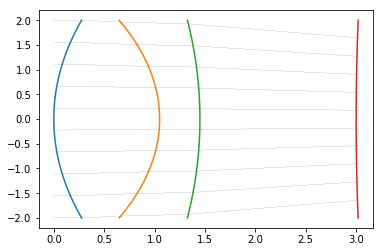

OSC


array([-0.16686926,  0.55418361, -0.37925888, -0.        ])

In [3]:
### Testing a textbook example
ls=lens_system(2)
ls.surfaces=[]
ls.add_surface(surface(0,1/7.3895,1,1.517,4))
ls.add_surface(surface(0+1.05,-1/5.1784,1.517,1.649,4))
ls.add_surface(surface(0+1.45,-1/16.2225,1.649,1,4))
ls.add_surface(surface(3,1/100.,1,1,4))
ls.plot()
print(ls.get_n())
bb=beam_field()        
bb.rectangular_grid(1,10,ls.entrance_pupil,0.00)
bb.propagate(ls.surfaces)
bb.plot(color='black')
bb2=beam_field()
bb2.single_beam_from_Kingslake_Q(2,0)
bb2.propagate(ls.surfaces)
print(bb2.U)
#bb2.plot(color='red',lw=1)
#print('king')
#print(bb2.Kingslake_Qabs(ls.surfaces))
#print(bb2.Kingslake_Q_abs(ls.surfaces))
#print('king')

#print(ls.surfaces[2].C)

plt.show()
print('OSC')
ls.OSC(-0.0874887)
ls.LA_contribution()

In [ ]:
a=np.array([[0,0,1]])
b=np.array([3,4,5,6])
c=a*b[:,np.newaxis]
d=np.array([[1,2,3,8],[4,5,6,7]])
e=d.T[:,:,np.newaxis]*a[np.newaxis,:,:]-c[:,np.newaxis,:]
np.sum(e,axis=2)[:,:,np.newaxis]
[i for i in b]
a=[1]
np.append([1],[2])
a=[1,2,3,4,5]
len(a)

In [125]:
power=0.0120
p1=0.008201
power2=0.01005
p2=+0.00001
z1=50.8
power3=-0.0106


z0=20
ls=lens_system(10)
ls.surfaces=[]
ls.add_surface(surface(z0,-1/2000.,1,1.514))
#ls.add_surface(surface(z0+12,-0.0091344908007259900E-002 ,1.514,1))
ls.add_surface(surface(z0+3.5,1/38.6 ,1.514,1))
#biconvex f=125
ls.add_surface(surface(z1,1/100.,1,1.514))
ls.add_surface(surface(z1+11.8,-1/100.,1.514,1))

#Achromat 150
#ls.add_surface(surface(165,4.037141703673800000E-003 ,1,1.6656))
#ls.add_surface(surface(165+3,1.386577925679420000E-002 ,1.6656,1.514))
#ls.add_surface(surface(165+23,-1.202212070209180000E-2 ,1.514,1))

#ls.add_surface(surface(z1,-13.051142341210599900E-003 ,1,1.514))
#ls.add_surface(surface(z1+11.8,0.051142341210599900E-003 ,1.514,1))

#Achromat
#ls.add_surface(surface(z1,0.0040371417036738,1,1.7258))
#ls.add_surface(surface(z1+3,0.0239865675221876,1.7258,1.66))
#ls.add_surface(surface(z1+23,-0.0196850393700787,1.66,1))

#inverted f=75 achromat
#ls.add_surface(surface(190,0.0040371417036738,1,1.7258))
#ls.add_surface(surface(190+3,0.0239865675221876,1.7258,1.66))
#ls.add_surface(surface(190+23,-0.0196850393700787,1.66,1))
#f=75 achromat
#ls.add_surface(surface(190,0.0196850393700787,1,1.66))
#ls.add_surface(surface(190+20,-0.0239865675221876,1.66,1.7258))
#ls.add_surface(surface(190+23,-0.0040371417036738,1.7258,1))

#f=250 achromat
ls.add_surface(surface(165, 7.294478080093399900E-003   ,1,1.5139))
ls.add_surface(surface(165+20, -8.953353030709999500E-003   ,1.5139,1.6411))
ls.add_surface(surface(165+23, -2.177700348432099900E-003  ,1.6411,1))
#f=200 achromat
#ls.add_surface(surface(165,9.102494083378799600E-003  ,1,1.5139))
#ls.add_surface(surface(165+20,-1.073998496402110000E-002  ,1.5139,1.6411))
#ls.add_surface(surface(165+23, -2.657807308970099800E-003  ,1.6411,1))
#f=150 achromat
#ls.add_surface(surface(165,1.202212070209180000E-2 ,1,1.514))
#ls.add_surface(surface(165+20,-1.386577925679420000E-002 ,1.514,1.6656))
#ls.add_surface(surface(165+23,-4.037141703673800000E-003 ,1.6656,1))
#f=100 achromat
#ls.add_surface(surface(190, 1.406074240719910000E-002  ,1,1.665))
#ls.add_surface(surface(190+20,-2.263980076975320000E-002  ,1.665,1.7196))
#ls.add_surface(surface(190+23, -2.754062241806699900E-003  ,1.7196,1))
#f=150 achromat
ls.add_surface(surface(190,1.202212070209180000E-2 ,1,1.514))
ls.add_surface(surface(190+20,-1.386577925679420000E-002 ,1.514,1.6656))
ls.add_surface(surface(190+23,-4.037141703673800000E-003 ,1.6656,1))


ls.add_surface(surface(220,5.0e-7,1,1.514))
ls.add_surface(surface(226.6,1.0e-7,1.514,1))
ls.add_surface(surface(290,0.0001,1,1.1))
ls.Spherical_aberrations_surface_addup()
def create_77_150_d():
    s=lens_system(10)
    s.surfaces=[]

    s.add_surface(surface(40,-1/2000000.,1,1.514))
    s.add_surface(surface(40+3.5,1/51.6 ,1.514,1))
    #convex f=300
    s.add_surface(surface(80,1/150.,1,1.514))
    s.add_surface(surface(80+11.8,-1/150.,1.514,1))
    #f=150 achromat
    s.add_surface(surface(165,1.202212070209180000E-2 ,1,1.514))
    s.add_surface(surface(165+20,-1.386577925679420000E-002 ,1.514,1.6656))
    s.add_surface(surface(165+23,-4.037141703673800000E-003 ,1.6656,1))
    #f=150 achromat
    s.add_surface(surface(190,1.202212070209180000E-2 ,1,1.514))
    s.add_surface(surface(190+20,-1.386577925679420000E-002 ,1.514,1.6656))
    s.add_surface(surface(190+23,-4.037141703673800000E-003 ,1.6656,1))

    s.add_surface(surface(220,5.0e-7,1,1.456))
    s.add_surface(surface(226.6,1.0e-7,1.456,1))
    s.add_surface(surface(290,0.0001,1,1.1))
    return s

[[             nan]
 [ -3.18044827e-02]
 [ -5.83389640e+00]
 [ -1.76362948e+01]
 [ -1.37492206e+03]
 [ -2.13360176e+01]
 [ -4.50366097e+01]
 [ -1.29550837e+01]
 [ -3.71220141e+00]
 [ -7.73385229e+00]
 [ -2.01338456e+00]
 [ -3.66310231e+00]
 [ -2.03936720e+00]
 [ -2.24284198e+00]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in subtract


In [133]:
#optrimize lens system
def optimize_lenses_ff(x):
    #P2=x[2]
    #P2=x[1]
    P3=x[0]
    #P6=x[2]
    P6=0.0001
    #p4=x[1]
    p1=x[1]
    p4=x[0]
    p5=0
    #P1=x[2]
    #ls.surfaces[4].set_Power(P1)
    #ls.surfaces[3].set_Curv((-P2)/200)
    #ls.surfaces[2].set_Curv((P2)/200)
    #ls.surfaces[1].set_Curv(P3/100)
    #ls.surfaces[0].set_Curv(P6/100)
    ls.surfaces[0].pos=p1
    ls.surfaces[1].pos=p1+3.5
    error=0
   # if x[1]<14:
    #    error=(14-x[2])**2

    #biconvex
    ls.surfaces[2].pos=p4+p1
    ls.surfaces[3].pos=p4+11.8+p1

    #Achromat
    #ls.surfaces[2].pos=p4+p1
    #ls.surfaces[3].pos=p4+3+p1
    #ls.surfaces[4].pos=p4+23+p1

    err3=0
    if(p4<14) or (p4+25+p1>165):
        err3=1
      #  print('err')
    
    ls.calculate_marginal()
   
    mpoint=ls.marginal_ray.Q_p[-4,0,1]
    #mpoint=max(ls.marginal_ray.Q_p[:,0,1])
    ls.entrance_pupil = ls.entrance_pupil*15.7/mpoint
    ls.calculate_marginal()
   
    osc=sum(ls.OSC(-0.0074887))
    if abs(osc)<0.001:
        osc=0
    res=ls.circle_of_least_confusion()
    #print(res,x)
    rr=res[1]
    #if res[1]<0.001:
    #    rr=0
    return rr+(res[0]-179.5)**2/1000000*0+err3+osc*osc*0


ls=create_77_150_d()
res=minimize(optimize_lenses_ff,([53,-60]), method='Nelder-Mead',tol=1e-4)
#res=minimize(optimize_lenses_ff,(next_start), method='Nelder-Mead',tol=1e-4)
#res=minimize(optimize_lenses_ff,([-0.945,0.917]), method='SLSQP',tol=1e-6)
##res=minimize(optimize_lenses_ff,([-0.75,0,0.72]), method='Nelder-Mead',tol=1e-4)
print(res)
next_start=res.final_simplex[0][0]

 final_simplex: (array([[  54.20566876, -100.70093849],
       [  54.20566802, -100.70086503],
       [  54.20566802, -100.70085507]]), array([ 0.00138853,  0.00138854,  0.00138855]))
           fun: 0.0013885310212025104
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 58
        status: 0
       success: True
             x: array([  54.20566876, -100.70093849])


<bound method surface.R of <__main__.surface object at 0x7fc9e3f77550>>
(269.76430056547673, 0.0013885310212025104)


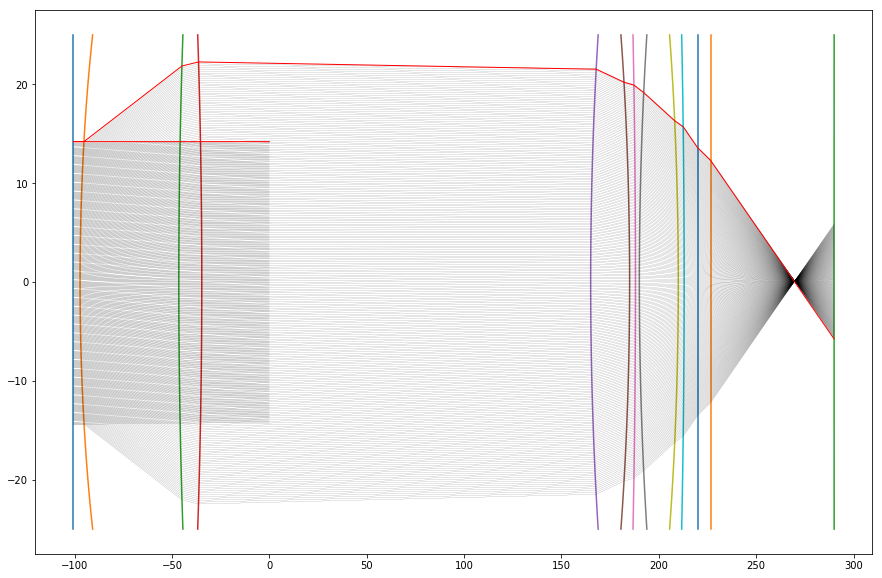

-5e-07 -2000000.0
0.01937984496124031 51.6
0.006666666666666667 150.0
-0.006666666666666667 -150.0
0.0120221207020918 83.18000000000033
-0.0138657792567942 -72.12000000000016
-0.0040371417036738 -247.69999999999993
0.0120221207020918 83.18000000000033
-0.0138657792567942 -72.12000000000016
-0.0040371417036738 -247.69999999999993
5e-07 2000000.0
1e-07 10000000.0
0.0001 10000.0
14.1993191994


In [134]:
#optimize_lenses_ff([-1.0418625,  0.817    ])
#optimize_lenses_ff([ -1.04930741,  0.81583173  ])
print(ls.surfaces[3].R)
#ls.entrance_pupil=16
#s=ls.surfaces[-1]
#ls.surfaces=ls.surfaces[:-1]
#ls.add_surface(surface(100,0.00000000003,1,1.514))
#ls.add_surface(surface(104,0.000000000000001,1.514,1))
#ls.surfaces.append(s)
#for i in [0,1,2,3]:
#    ls.surfaces[i].set_Curv(1E-3)
plt.figure(figsize=(15,10))
ls.plot()
#ls.plot_caustic(marker='.',lw=0.01)
ls.calculate_marginal()
#a=ls.calculate_width_helper(-0.1)
#print(a)
#i=ls.calculate_width()
#print(i)
CLC=ls.circle_of_least_confusion()
print(CLC)
zoom=0.02
offset=0.09*1
#plt.xlim(CLC[0]-5*zoom,CLC[0]+5*zoom)
#plt.ylim(-1*zoom+offset,1*zoom+offset)
#plt.xlim(112.9,113.1)
#plt.ylim(10,25)
bb=beam_field()        
bb.rectangular_grid(1,250,ls.entrance_pupil,0.002*1)
bb.propagate(ls.surfaces)
bb.plot(color='black')
ls.calculate_marginal()


ls.marginal_ray.plot(color='red',lw=1)
plt.show()
for sss in ls.surfaces:
  print(sss.C,sss.R())
print(ls.entrance_pupil)

In [135]:
print(sum(ls.OSC(-0.0074887)))
ls.LA_contribution()
print(ls.OSC(-0.0074887))

#ls.Spherical_aberrations_surface_addup()
#ls.surfaces[-1].set_Curv(np.float64(-.1E-11))
#par=paraxial()
#par.propagate(ls.surfaces)
#print(par.y,par.nu)

-0.0339180206406
[ -5.65174707e-12  -6.12668387e-02   1.71117497e-02   5.57427112e-03
  -1.31197799e-02   6.03565709e-03   3.80836254e-03   1.76522551e-03
   1.13037111e-02  -4.79820692e-03  -1.35174539e-03   1.22525622e-03
  -2.05683026e-04]


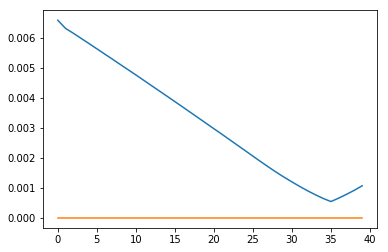

In [119]:
def optimize_lenses_ff2(x):
    p1=x[0]
    p4=x[1]
    ls.surfaces[0].pos=p1
    ls.surfaces[1].pos=p1+3.5
    error=0
    ls.surfaces[2].pos=p4+p1
    ls.surfaces[3].pos=p4+11.8+p1

    err3=0
    if(p4<14) or(p4+15+p1>165):
        err3=1
        print('err')
    
    
    ls.calculate_marginal()
   
    mpoint=ls.marginal_ray.Q_p[-4,0,1]
    #mpoint=max(ls.marginal_ray.Q_p[:,0,1])
    ls.entrance_pupil = ls.entrance_pupil*15.7/mpoint
    
    osc=sum(ls.OSC(-0.0074887))
    
    res=ls.circle_of_least_confusion()
    #print(res,x)
    rr=res[1]
   
    return rr,osc
ls=create_77_150_d()
dat=[]
x=np.linspace(35,45,40)
for k in x:
    rr,osc=optimize_lenses_ff2([k,20.5])
#res=minimize(optimize_lenses_ff2,([59]), args=(15),method='Nelder-Mead',tol=1e-3)
    #print(rr,osc)
    dat.append([rr,osc])
dat=np.array(dat)
#plt.plot(dat[:,1])
plt.plot(dat[:,0])
plt.plot(x*0)
plt.show()

In [80]:
optimize_lenses_ff2([x[23],35.5])

(0.0019561267848091646, -0.00033262433728942665)

In [ ]:
def create_51_250_d150():
    s=lens_system(10)
    s.surfaces=[]

    s.add_surface(surface(44.1578208,-1/2000000.,1,1.514))
    s.add_surface(surface(44.1578208+3.5,1/51.6 ,1.514,1))
    #convex f=300
    s.add_surface(surface(44.1578208+14.2650827,1/250.,1,1.514))
    s.add_surface(surface(44.1578208+14.2650827+11.8,-1/250.,1.514,1))
    #f=150 achromat
    s.add_surface(surface(165,1.202212070209180000E-2 ,1,1.514))
    s.add_surface(surface(165+20,-1.386577925679420000E-002 ,1.514,1.6656))
    s.add_surface(surface(165+23,-4.037141703673800000E-003 ,1.6656,1))
    #f=150 achromat
    s.add_surface(surface(190,1.202212070209180000E-2 ,1,1.514))
    s.add_surface(surface(190+20,-1.386577925679420000E-002 ,1.514,1.6656))
    s.add_surface(surface(190+23,-4.037141703673800000E-003 ,1.6656,1))

    s.add_surface(surface(220,5.0e-7,1,1.456))
    s.add_surface(surface(226.6,1.0e-7,1.456,1))
    s.add_surface(surface(290,0.0001,1,1.1))
    return s

###### def f1(x,y=1,*args):
 1e-06
0.0198186296182
0.00796414948334
-0.00796414948334
0.0196850393700787
-0.0239865675221876
-0.0040371417036738
5e-07
1e-07
0.0001

In [29]:
ls=create_77_150_d()

(271.03858812794692, 0.060705820038244873)


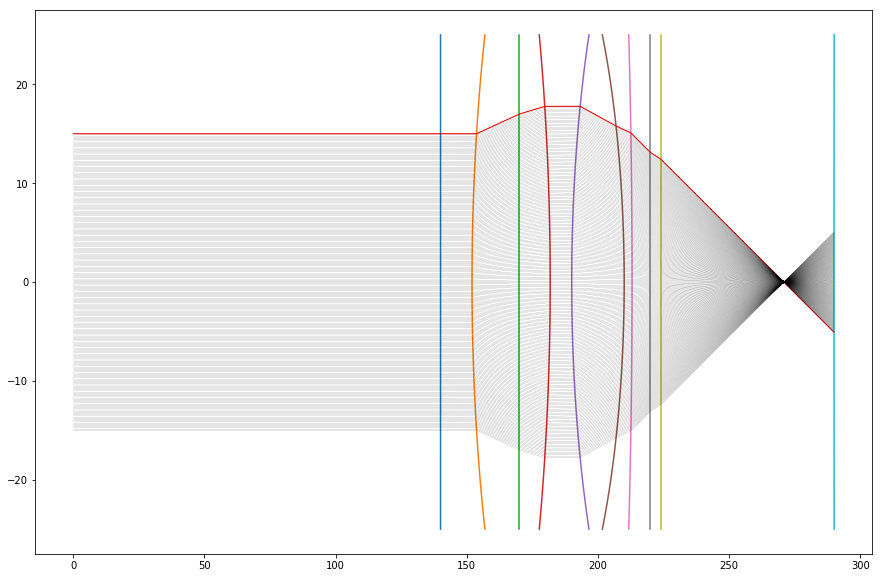

In [1646]:
ls=lens_system(15)
ls.surfaces=[]
z0=140
z1=z0+30
ls.add_surface(surface(z0,-0.001E-002,1,1.514))
ls.add_surface(surface(z0+12,+1.51E-2 ,1.514,1))
#ls.add_surface(surface(z0+5,2.591344908007259900E-002 ,1.514,1))
#ls.add_surface(surface(z1,7.851142341210599900E-003 ,1,1.514))
#ls.add_surface(surface(z1+11.8,-7.851142341210599900E-003 ,1.514,1))
#ls.add_surface(surface(z0+5,2.591344908007259900E-002 ,1.514,1))
#ls.add_surface(surface(z1,7.851142341210599900E-003 ,1,1.514))
#ls.add_surface(surface(z1+11.8,-7.851142341210599900E-003 ,1.514,1))
ls.add_surface(surface(z1,0.00050E-003 ,1,1.514))
ls.add_surface(surface(z1+11.8,-13.00E-003 ,1.514,1))

ls.add_surface(surface(190,0.0196850393700787,1,1.66))
ls.add_surface(surface(190+20,-0.0239865675221876,1.66,1.7258))
ls.add_surface(surface(190+23,-0.0040371417036738,1.7258,1))
ls.add_surface(surface(220,5.0e-7,1,1.514))
ls.add_surface(surface(224,1.0e-7,1.514,1))
ls.add_surface(surface(290,0.0001,1,1.1))
ls.OSC(-0.0174887)
ls.LA_contribution()
plt.figure(figsize=(15,10))
ls.plot()
ls.calculate_marginal()
ls.marginal_ray.plot(color='red',lw=1)

CLC=ls.circle_of_least_confusion()
print(CLC)
bb=beam_field()        
bb.rectangular_grid(1,250,ls.entrance_pupil,0.00)
bb.propagate(ls.surfaces)
bb.plot(color='black')

plt.show()


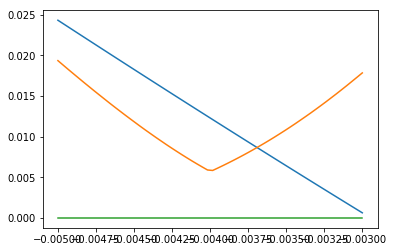

30
59


array([ 0.02432542,  0.0239124 ,  0.02349976,  0.02308749,  0.0226756 ,
        0.02226409,  0.02185295,  0.0214422 ,  0.02103182,  0.02062183,
        0.02021222,  0.01980299,  0.01939415,  0.0189857 ,  0.01857763,
        0.01816994,  0.01776265,  0.01735574,  0.01694923,  0.0165431 ,
        0.01613737,  0.01573203,  0.01532709,  0.01492254,  0.01451839,
        0.01411463,  0.01371127,  0.01330831,  0.01290575,  0.01250359,
        0.01210183,  0.01170047,  0.01129952,  0.01089897,  0.01049883,
        0.01009909,  0.00969976,  0.00930084,  0.00890233,  0.00850423,
        0.00810653,  0.00770925,  0.00731238,  0.00691593,  0.00651989,
        0.00612427,  0.00572906,  0.00533427,  0.00493989,  0.00454594,
        0.0041524 ,  0.00375929,  0.0033666 ,  0.00297433,  0.00258248,
        0.00219106,  0.00180006,  0.00140949,  0.00101935,  0.00062963])

In [726]:
oscs=[]
las=[]
ls.OSC(-0.0174887)
ls.LA_contribution()
CLC=[]
ax=np.linspace(-5E-3,-3.0E-3,60)
for a in ax:
    ls.surfaces[0].set_Curv(-a)
    ls.surfaces[1].set_Curv(1.5E-2-a)
    oscs.append(ls.OSC(-0.0174887))
    las.append(ls.LA_contribution())
    CLC.append(ls.circle_of_least_confusion()[1])
oscs=np.sum(np.array(oscs),axis=1)
plt.plot(ax,oscs)
#plt.show()
#fig=plt.figure()
plt.plot(ax,CLC)
plt.plot(ax,ax*0)
plt.show()
print(np.argmin(CLC))
print(np.argmin(oscs*oscs))
oscs

[ 1.]
[ 1.514]
[ 1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  

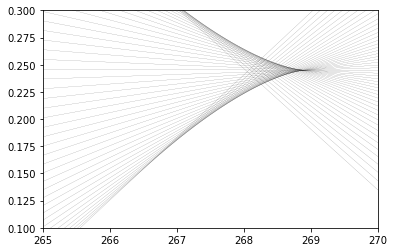

In [4]:
ls1=lens_system(13.8)
ls1.surfaces=[]
ls1.add_surface(surface(20,1/125.,1,1.514))
ls1.add_surface(surface(20+11.8,0.00006,1.5,1))
ls1.add_surface(surface(640,.0001,1,1.1))
ls1.calculate_marginal()

CLC=ls1.circle_of_least_confusion()
print(CLC)
print(ls1.surfaces[0].R)
print(CLC[0]-34)
ls1.plot()
ls1.plot_caustic()
bb=beam_field()        
bb.rectangular_grid(1,50,13.8,0.001)
bb.propagate(ls1.surfaces)
bb.plot()
plt.xlim(265,270)
plt.ylim(0.1,0.3)
plt.show()


[ 1.]
[ 1.66]
[ 1.7258]
[ 1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. 

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
[ 1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66
  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66]
[ 1.7258  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258
  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258  1.7258
  1.7258  1.7258]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66
  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66
  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66
  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66  1.66
  1.66  1.66]
[ 1.7258  1.7258  1.7258  1.7258  1.7

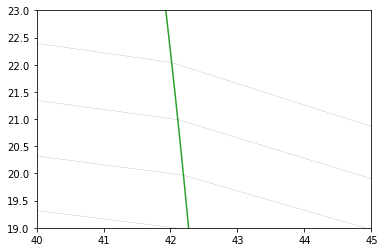

In [7]:
ls1=lens_system(20)
ls1.surfaces=[]
ls1.add_surface(surface(20,1.968503937007870200E-002 ,1,1.66))
ls1.add_surface(surface(20+20,-2.398656752218759900E-002 ,1.66,1.7258))
ls1.add_surface(surface(20+23,-4.037141703673800000E-003 ,1.7258,1))

ls1.add_surface(surface(140,.0001,1,1.1))
ls1.calculate_marginal()
CLC=ls1.circle_of_least_confusion()
print(CLC)
print(ls1.surfaces[0].R)
print(CLC[0]-34)
ls1.plot()
ls1.plot_caustic()
bb=beam_field()        
bb.rectangular_grid(1,50,25)
bb.propagate(ls1.surfaces)
bb.plot()
plt.xlim(40,45)
plt.ylim(19,23)
plt.show()


 Exercise: Comparing Primary Mirror Specs in Different Formats
Filed under: Simulation — lsstlog @ 11:09 am

The primary mirror is defined separately in at least 4 places now: Table-1 of Document-1361, Document-451 (OSLO), Document-559 (Zemax), and hardcoded within lsstsim.c. These don't seem to agree in detail (see below).

The online docs for OSLO do not define the syntax for the specific commands appearing in the input file, but the online help for their free OSLO EDU product does (after I installed it). Here is their symmetric aspheric equation:

OSLO ASphere equation

I can't find any online docs for Zemax except for this knowledge base, which doesn't help much. Their free demo includes a PDF user's guide, which lists the Even ASphere parameters as alpha_1,… = a_2, a_4, a_6, …, a_16 in this equation:

Zemax ASphere equation
Z(r)=cr^2/(1+\sqrt(1-(1+k)c^2r^2))+\alpha_1 r^2+\alpha_2 r^4+\alpha_3 r^6 + ...

For zmx files
General
ENPD (clear apperture (collimation)
WAVM 1 = Design wavelength
Surfaces:
(in our example lens starts at SURF 1, Aspheric surface is SURF 1, SURF2 is second side SURF is at working distance)

The parm parameters correspond to alphas
CONI is the conic constant k
CURV = C is (corresponds to 1/R)
DISZ = distance after surface(all disz add up)
DIAM = radius of the surface (surface 2 corresponds to clear aperture) 
Extracted from the OSLO definition:

NOT "primary"
NXT  // SRF 4
RFH
RD   -6788.0
PK TH   -2 0.0
AP CHK 1710.0
CC   -0.222
AD    0.0
AE   -1.274e-20
AF   -9.68e-28
APN  1
AY1 A -900.0
AY2 A 900.0
AX1 A -900.0
AX2 A 900.0
ATP A 1
AAC A 2

Extracted from the Zemax definition:

SURF 11
  COMM primary mirror
  STOP
  TYPE EVENASPH
  CURV -5.041593143433E-005 0 0.000000000000E+000 0.000000000000E+000
  HIDE 0 0 0 0 0 0
  SLAB 17
  PARM 1 0.000000000000E+000
  PARM 2 0.000000000000E+000
  PARM 3 1.381000000000E-024
  PARM 4 0.000000000000E+000
  PARM 5 0.000000000000E+000
  PARM 6 0.000000000000E+000
  PARM 7 0.000000000000E+000
  PARM 8 0.000000000000E+000
  DISZ -9.000000000000E+002
  GLAS MIRROR 0 0 1.50000000 40.00000000 0.00000000 0 0 0 0.00000000 0.00000000
  CONI -1.215000000000E+000
  DIAM 4.193511292182E+003 0 3
  POPS 0 0 0 0 0 0 0 0 1 1 1.000000000000E+000 1.000000000000E+000 0 0.000000000000E+000 0.000000000000E+000
  CLAP 2.558000000000E+003 4.180000000000E+003 0

Extracted from lsstsim.c ("SHORT TUBE 3.5m degree design"):

asphere(surface+npoints*(1-1),surface_r+npoints*(1-1),surface_normal+npoints*(1-1),npoints,
    19200,0.0,4180,2613,
    -1.254809,0.0,5.8773e-27,0.0,0.0);

void asphere (double *surface, double *surface_r, double *surface_normal, long numelements,
    double radiusofcurv, double spacing, double semidiameter, double holesemi,
    double conic, double fourth,double sixth, double eighth, double tenth) { ... }

Here is a comparison of the Doc-1361 | OSLO | Zemax | lsstsim parameter values used above:

    1/C = radius of curvature = -19835mm | -6788.0 | 1/(-5.0416e-5)=-19835.0mm | 19200mm
    k = conic constant = -1.215 | -0.222 | -1.215 | -1.254809
    a_6 = +1.38e-24 | -1.274e-20 | -1.281e-24 | -5.8773e-27
    a_8 = 0 | -9.68e-28 | 0 | 0

Why is the OSLO radius of curvature so different? 19835/6733 = 2.922, so its not in inches. The ratio for a_6 is 1/9225.2, but a_6 has dimensions of 1/L^5 so compare 2.922 with 9225.2^(1/5) = 6.2. Hmm.

The asphere(…) subroutine in lsstsim.c multiplies the coefficients a_k by 10^3 internally, so it uses a value of a_6 similar to the other sources (except OSLO).

 Conclusion: lsstsim.c is using a slightly out of date design, ZEMAX and Doc-1361 are almost (but not quite) identical, and the OSLO design doesn't make any sense yet.

In [50]:
dd={'dd':'ff'}
dd.get('dd',0)

'ff'